In [ ]:
# please use data_viz1 as your environment. data_viz0 is having some problems.

In [1]:
import dill
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Dihedral

import mdtraj as md

import matplotlib.pyplot as plt
from collections import Counter

import os
from typing import Optional, List, Tuple

/home/bfd21/rds/hpc-work/miniconda3/envs/data_viz1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**First Order of Business:** let's see if our conditioning consistantly picked the correct loss strategy when presented with cyclic peptide data

In [2]:
strategies_batches = [
    f'/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_losses_selected_batch-{i}.pkl' for i in range(4)
]

strategies_list = []

for batch_str in strategies_batches:
    # Load from the file
    with open(batch_str, "rb") as f:
        loaded_list = dill.load(f)
    
    for j in loaded_list:
        strategies_list.append(j)

In [39]:
count = 0

for i in strategies_list:
    if i == strategies_list[0]:
        count += 1

print(count) # per the below output, it picked the correct outcome every single time.

400


**Nice! Now onto next objective:** We want to do PCA on the dihedral angles, maybe bond angles, on the generated samples, and compare where they lie in this PCA space to the raw validation data.

It should be noted that the below data, when conditioned on cyclicality, is merely conditioned right now on bond lengths. Dihedrals and bond angles are to come, and are fairly easy to implement from a programming perspective. However, I am still in the process of actually solving for said dihedrals with something like ORCA.

In [3]:
def generate_mdtraj_trajectory(pdb_path, data_files, print_shape = False):
    """
    Loads a PDB file, infers bonds, processes NPZ and NPY files, and constructs an MDTraj trajectory.

    Parameters:
        pdb_path (str): Path to the PDB file.
        data_files (list of str): List of paths to NPZ or NPY files containing sampled atomic positions.

    Returns:
        mdtraj.Trajectory: The generated trajectory with inferred bonds and centered coordinates.
    """

    # Load PDB and infer bonds
    pdb = md.load(pdb_path)
    pdb.topology.create_standard_bonds()  # Infer bonds based on atom types and residue connectivity
    topology = pdb.topology

    # Load and process generated samples
    all_samples = []
    for data_file in data_files:
        file_extension = os.path.splitext(data_file)[1]

        if file_extension == ".npz":
            data = np.load(data_file)
            samples_np = data["samples_np"]  # Extract the relevant array from NPZ
        elif file_extension == ".npy":
            samples_np = np.load(data_file)  # Load directly from NPY
        else:
            raise ValueError(f"Unsupported file format: {data_file}")

        # Reshape samples to match the number of atoms in the PDB
        n_atoms = len(list(topology.atoms))
        samples = samples_np.reshape(-1, n_atoms, 3)  # (n_frames, n_atoms, 3)
        all_samples.append(samples)

    # Combine all samples into a single array
    all_samples = np.concatenate(all_samples, axis=0)
    if print_shape:
        print(all_samples.shape)

    # Create an MDTraj trajectory with the inferred bonds
    traj = md.Trajectory(
        xyz=all_samples,  # Shape: (n_frames, n_atoms, 3)
        topology=topology
    )

    # Center the trajectory around the origin
    traj.center_coordinates()

    return traj

def compute_all_dihedrals(traj):
    """
    Computes backbone (phi, psi, omega) and side-chain (chi1, chi2, chi3, chi4) dihedral angles 
    for all amino acids in the given trajectory.
    
    Parameters:
        traj (mdtraj.Trajectory): MDTraj trajectory object.
    
    Returns:
        dict: Dictionary containing dihedral angles in degrees.
    """

    # Compute backbone dihedral angles
    phi_indices, phi_angles = md.compute_phi(traj)
    psi_indices, psi_angles = md.compute_psi(traj)
    omega_indices, omega_angles = md.compute_omega(traj)

    # Compute side-chain chi angles (some may be empty depending on the peptide)
    chi1_indices, chi1_angles = md.compute_chi1(traj)
    chi2_indices, chi2_angles = md.compute_chi2(traj)
    chi3_indices, chi3_angles = md.compute_chi3(traj)
    chi4_indices, chi4_angles = md.compute_chi4(traj)

    dihedral_angles = {
        "phi": phi_angles,
        "psi": psi_angles,
        "omega": omega_angles,
        "chi1": chi1_angles if chi1_angles.size else None,
        "chi2": chi2_angles if chi2_angles.size else None,
        "chi3": chi3_angles if chi3_angles.size else None,
        "chi4": chi4_angles if chi4_angles.size else None,
    }

    return dihedral_angles

default_keys = ['phi', 'omega', 'psi', 'chi1', 'chi2', 'chi3']

def concat_dihedrals(dihedrals_dict, keys = default_keys):
    # Concatenate along axis=1 to preserve n_samples while summing the second dimension
    all_dihedrals = np.concatenate([dihedrals_dict[key] for key in keys], axis=1) # shape should be (n_samples, n_dihedrals)

    return all_dihedrals

def data_to_dihedrals_vecs(pdb_path, data_files, keys = default_keys):
    '''Wraps generate_mdtraj_trajectory -> compute_all_dihedrals -> concat_dihedrals,
    for the sake of cleanliness.
    '''

    traj = generate_mdtraj_trajectory(pdb_path, data_files)
    dihedrals_dict = compute_all_dihedrals(traj)
    final_vecs = concat_dihedrals(dihedrals_dict, keys = keys)
    
    return final_vecs

################################################################
# unfortunately, I couldn't get sklearn to work in this env.
# therefore, I have just had chat GPT implement PCA in numpy
# Thanks, Chat GPT :)
################################################################

def pca_numpy(data, n_components: int):
    """
    Perform PCA using NumPy's eigenvalue decomposition.

    Parameters:
        data (numpy.ndarray): Input data of shape (n_samples, n_features).
        n_components (int): Number of principal components to keep.

    Returns:
        principal_components (numpy.ndarray): The principal component vectors (n_features, n_components).
        explained_variance (numpy.ndarray): Explained variance ratio of each principal component.
    """
    # Center the data
    data_mean = np.mean(data, axis=0)
    data_centered = data - data_mean

    # Compute covariance matrix
    covariance_matrix = np.cov(data_centered, rowvar=False)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]  # Sorted eigenvalues
    eigenvectors = eigenvectors[:, sorted_indices]  # Sorted eigenvectors

    # Compute explained variance ratio
    explained_variance = eigenvalues[:n_components] / np.sum(eigenvalues)

    # Select the top 'n_components' eigenvectors
    principal_components = eigenvectors[:, :n_components]

    return principal_components, explained_variance

def project_data(data, principal_components, center: np.array = None):
    """
    Projects data onto the given principal components.

    Parameters:
        data (numpy.ndarray): Input data of shape (n_samples, n_features).
        principal_components (numpy.ndarray): Principal components of shape (n_components, n_features).

    Returns:
        projected_data (numpy.ndarray): Data projected onto principal components of shape (n_samples, n_components).
    """
    # Center the data

    if center is not None:
        # center should be of shape (n_features, )
        data_centered = data - center
    else:
        data_centered = data

    # Compute projection: dot product with principal components
    projected_data = np.dot(data_centered, principal_components.T)  # Shape: (n_samples, n_components)

    return projected_data

def plot_pca_scatter(projected_data_list, colors, alpha=0.5, s=2, legend: Optional[List[str]] = None, title: Optional[str] = None):
    """
    Plots multiple PCA-projected datasets in 2D space with each dataset having its own color.

    Parameters:
        projected_data_list (list): A list of numpy arrays, each of shape (n_samples, 2), where each entry represents a PCA projection.
        colors (list): A list of colors, one for each dataset.
        alpha (float): Transparency of points (default 0.5).
        s (int): Size of points (default 2).
        legend (list): self explanatory
        title (str): self explanatory
    
    Returns:
        None (displays plot).
    """
    plt.figure(figsize=(8, 6))
    
    # Loop through the datasets and their corresponding colors
    for data, color in zip(projected_data_list, colors):
        plt.scatter(data[:, 0], data[:, 1], alpha=alpha, s=s, color=color)
    
    # Formatting
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA Projection of Multiple Datasets")
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)  # Add horizontal axis
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)  # Add vertical axis
    plt.grid(True, linestyle="--", alpha=0.5)
    if legend is not None:
        plt.legend(legend)
    if title is not None:
        plt.title(title)
    
    # Show plot
    plt.show()

**First Test:** We will compare where the conditionally & unconditionally generated samples lie in PCA space compared to the validation data (all data)

In [4]:
# This cell shall principly assemble all file names relevant to our analysis.
# pdb_path
pdb_path = '/home/bfd21/rds/hpc-work/data/MDM2-sample-binders/ligand-only/l1/ligand1.pdb'

#actual data
cond_cyc_unc_time_inference_list = [f'/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-3.npz']
#cond_cyc_cond_time_inference_list = # we will certainly want to add this later to our analysis, to see how conditioning on time changes the quality of the inference in PCA space.
unc_cyc_unc_time_inference_list = [f'/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-11/unconditioned-on-cyc/unconditioned-on-time/unc-cyc-unc-time-l1-inference_batch-3.npz']
raw_validation_data = ['/home/bfd21/rds/hpc-work/data/MDM2-sample-binders/ligand-only/l1/splits/l1_val.npy']

In [5]:
cond_cyc_unc_time_inference_vecs = data_to_dihedrals_vecs(pdb_path, cond_cyc_unc_time_inference_list)
unc_cyc_unc_time_inference_vecs = data_to_dihedrals_vecs(pdb_path, unc_cyc_unc_time_inference_list)
raw_val_vecs = data_to_dihedrals_vecs(pdb_path, raw_validation_data)

all_dihedral_vecs = np.concatenate([cond_cyc_unc_time_inference_vecs, unc_cyc_unc_time_inference_vecs, raw_val_vecs], axis=0)

pcs=[pca_numpy(all_dihedral_vecs, 2)[0][:, i] for i in range(2)]
pcs_arr = np.array(pcs) # (n_components, n_features)

pcs_arr_init = pcs_arr

all_mean = np.mean(all_dihedral_vecs, axis=0)
all_mean_init = all_mean

# now, we project this data onto our pcs
proj_cond_cyc_unc_time = project_data(cond_cyc_unc_time_inference_vecs, pcs_arr, center = all_mean)
proj_unc_cyc_unc_time = project_data(unc_cyc_unc_time_inference_vecs, pcs_arr, center = all_mean)
proj_raw = project_data(raw_val_vecs, pcs_arr, center = all_mean)

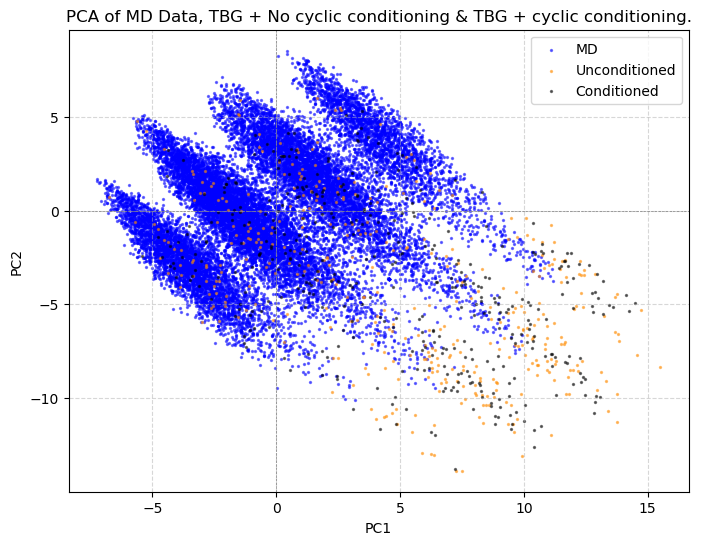

In [6]:
plot_pca_scatter([proj_raw, proj_unc_cyc_unc_time, proj_cond_cyc_unc_time], colors = ['b', 'darkorange', 'black'], legend = ['MD', 'Unconditioned', 'Conditioned'], title= 'PCA of MD Data, TBG + No cyclic conditioning & TBG + cyclic conditioning.')

**Next:** We will compare just conditioned & unconditioned data

In [7]:
all_artificial = np.concatenate([cond_cyc_unc_time_inference_vecs, unc_cyc_unc_time_inference_vecs], axis=0)

pcs=[pca_numpy(all_artificial, 2)[0][:, i] for i in range(2)]
pcs_arr = np.array(pcs) # (n_components, n_features)

pcs_arr_inf = pcs_arr

all_artificial_mean = np.mean(all_artificial, axis=0)

# now, we project this data onto our pcs
proj_cond_cyc_unc_time = project_data(cond_cyc_unc_time_inference_vecs, pcs_arr, center = all_artificial_mean)
proj_unc_cyc_unc_time = project_data(unc_cyc_unc_time_inference_vecs, pcs_arr, center = all_artificial_mean)

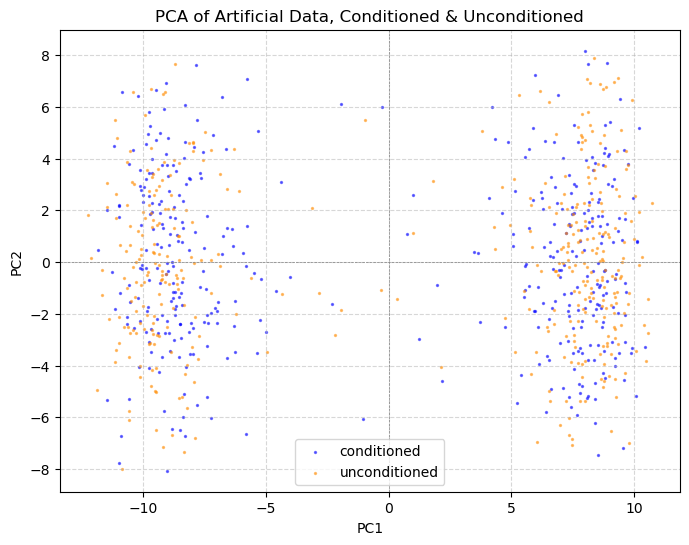

In [8]:
plot_pca_scatter([proj_cond_cyc_unc_time, proj_unc_cyc_unc_time], ['b', 'darkorange'], legend= ['conditioned', 'unconditioned'], title = 'PCA of Artificial Data, Conditioned & Unconditioned')

**Thirdly:** Now we want to investigate whether or not this reflection is actually occuring

In [9]:
pdb_path = '/home/bfd21/rds/hpc-work/data/MDM2-sample-binders/ligand-only/l1/ligand1.pdb'

# Function to compute the signed volume of a tetrahedron
def signed_tetrahedron_volume(a, b, c, d):
    return np.dot(np.cross(b - a, c - a), d - a) / 6.0

# Function to infer chirality of each alpha carbon
def infer_chirality(universe):
    chiral_centers = []
    for residue in universe.residues:
        try:
            # Extract the relevant atoms
            n = residue.atoms.select_atoms('name N')
            ca = residue.atoms.select_atoms('name CA')
            c = residue.atoms.select_atoms('name C')
            cb = residue.atoms.select_atoms('name CB')

            if len(n) == 1 and len(ca) == 1 and len(c) == 1 and len(cb) == 1:
                # Compute the signed volume of the tetrahedron
                volume = signed_tetrahedron_volume(
                    n.positions[0], ca.positions[0], c.positions[0], cb.positions[0]
                )

                # Determine chirality
                chirality = 'L' if volume < 0 else 'D'
                chiral_centers.append((residue.resname, residue.resid, chirality))
        except Exception as e:
            print(f'Error processing residue {residue.resname} {residue.resid}: {e}')
    return chiral_centers

def get_ref_chirality_vec(pdb_path: str):

    val_dict = {
        'L': 1,
        'D': -1,
    }

    universe = mda.Universe(pdb_path)
    chirality_list = infer_chirality(universe)

    val_arr = np.array([val_dict[tup[-1]] for tup in chirality_list])

    return val_arr

def get_chirality_vecs(data: md.Trajectory):
    """
    Computes the chirality of each alpha carbon across all frames in a given trajectory dataset.

    Parameters:
        data (mdtraj.Trajectory): A trajectory containing atomic positions.

    Returns:
        np.ndarray: An array of shape (n_frames, n_carbon_alphas) with values -1 for D-chirality and 1 for L-chirality.
    """
    
    val_dict = {
        'L': 1,
        'D': -1,
    }

    chiral_vectors = []

    for frame in range(data.n_frames):
        frame_chiralities = []
        
        for residue in data.topology.residues:
            try:
                # Extract atom indices
                n_idx = [atom.index for atom in residue.atoms if atom.name == 'N']
                ca_idx = [atom.index for atom in residue.atoms if atom.name == 'CA']
                c_idx = [atom.index for atom in residue.atoms if atom.name == 'C']
                cb_idx = [atom.index for atom in residue.atoms if atom.name == 'CB']

                if len(n_idx) == 1 and len(ca_idx) == 1 and len(c_idx) == 1 and len(cb_idx) == 1:
                    # Get positions from trajectory
                    n_pos = data.xyz[frame, n_idx[0]]
                    ca_pos = data.xyz[frame, ca_idx[0]]
                    c_pos = data.xyz[frame, c_idx[0]]
                    cb_pos = data.xyz[frame, cb_idx[0]]

                    # Compute chirality
                    volume = signed_tetrahedron_volume(n_pos, ca_pos, c_pos, cb_pos)
                    chirality = 'L' if volume < 0 else 'D'

                    frame_chiralities.append(val_dict[chirality])
                else:
                    frame_chiralities.append(0)  # Placeholder for missing data

            except Exception as e:
                print(f"Error processing residue {residue.index}: {e}")
                frame_chiralities.append(0)

        chiral_vectors.append(frame_chiralities)

    return np.array(chiral_vectors)

def process_data_sources(data_sources: List[str]) -> np.array:
    fin_list = []

    for data_file in data_sources:
        file_extension = os.path.splitext(data_file)[1]
        
        if file_extension == ".npz":
            data = np.load(data_file)
            samples_np = data["samples_np"]  # Extract the relevant array from NPZ
        elif file_extension == ".npy":
            samples_np = np.load(data_file)  # Load directly from NPY
        else:
            raise ValueError(f"Unsupported file format: {data_file}")
        
        fin_list.append(samples_np)
    
    return np.concatenate(fin_list, axis = 0)

def sample_chirality_vecs(data_sources: List[str], pdb_path: str):
    pdb = md.load(pdb_path)
    pdb.topology.create_standard_bonds()  # Infer bonds based on atom types and residue connectivity
    topology = pdb.topology

    n_atoms = pdb.topology.n_atoms
    all_data_np = process_data_sources(data_sources).reshape(-1, n_atoms, 3)

    traj_data = md.Trajectory(
        xyz = all_data_np,
        topology = topology,
    )

    vecs = get_chirality_vecs(traj_data)
    
    return vecs

def get_modify_indexes(chirality_vecs: np.array, ref_vec: np.array) -> np.array:
    """
    Determines whether each sample in chirality_vecs matches ref_vec, its negation, or neither.

    Args:
        chirality_vecs: A NumPy array of shape (n_samples, n_amino) representing chirality vectors.
        ref_vec: A NumPy array of shape (n_amino) representing the reference chirality vector.

    Returns:
        A NumPy array of shape (n_samples,) with values:
            1  -> if the sample matches ref_vec
           -1  -> if the sample matches -ref_vec
            0  -> if neither condition is met
    """
    is_match = np.all(chirality_vecs == ref_vec, axis=1)
    is_flip = np.all(chirality_vecs == -ref_vec, axis=1)
    
    return np.where(is_match, 1, np.where(is_flip, -1, 0))

def clean_samples(samples: np.array, mod_idxs: np.array, verbose: bool = True) -> np.array:
    """
    Modifies and filters samples based on mod_idxs.

    Args:
        samples: A NumPy array of shape (n_samples, n_atoms, 3), representing molecular structures.
        mod_idxs: A NumPy array of shape (n_samples,), indicating:
            - 1  -> Keep the sample unchanged.
            - -1 -> Reflect (invert chirality) of the sample by flipping the x-axis.
            - 0  -> Omit the sample.
        verbose: Whether to print the number of removed samples.

    Returns:
        A modified NumPy array of shape (filtered_n_samples, n_atoms, 3).
    """
    total_samples = samples.shape[0]
    removed_samples = np.sum(mod_idxs == 0)
    flipped_samples = np.sum(mod_idxs == -1)

    # Select samples to keep (mod_idxs != 0)
    mask = mod_idxs != 0
    filtered_samples = samples[mask]
    filtered_mod_idxs = mod_idxs[mask]  # Should be only -1 and 1 now.

    # Flip x-axis for samples where mod_idxs == -1
    filtered_samples[filtered_mod_idxs == -1, :, 0] *= -1  # Only flip x-coordinates

    # Print removal statistics
    if verbose:
        print(f"Total samples removed: {removed_samples} / {total_samples} ({removed_samples / total_samples:.2%})")
        print(f"Total samples flipped: {flipped_samples} / {total_samples} ({flipped_samples / total_samples:.2%})")

    return filtered_samples

def count_atoms_mdanalysis(pdb_file): # redundant, but fine for the number of atoms I am working with tbh
    """Counts the number of atoms in a given PDB file using MDAnalysis."""
    u = mda.Universe(pdb_file)
    return len(u.atoms)

def process_inference(data_sources: List[str], pdb_path: str, verbose: bool = True) -> np.array:
    ref_chirality_vec = get_ref_chirality_vec(pdb_path)
    print(ref_chirality_vec.shape) 
    inf_chirality_vecs = sample_chirality_vecs(data_sources=data_sources, pdb_path=pdb_path)
    print(inf_chirality_vecs.shape)

    n_atoms = count_atoms_mdanalysis(pdb_path)
    all_samples = process_data_sources(data_sources = data_sources).reshape(-1, n_atoms, 3) # need to change the shape of samples in this function.
    mod_idxs = get_modify_indexes(inf_chirality_vecs, ref_chirality_vec)
    c_samples = clean_samples(all_samples, mod_idxs, verbose = verbose)
    
    return c_samples

# ------------------------------------------------------ #
def np_to_dihedrals_vecs(pdb_path, np_data, keys = default_keys):
    '''Wraps np_generate_mdtraj_trajectory -> compute_all_dihedrals -> concat_dihedrals,
    for the sake of cleanliness.
    '''

    traj = np_generate_mdtraj_trajectory(pdb_path, np_data)
    dihedrals_dict = compute_all_dihedrals(traj)
    final_vecs = concat_dihedrals(dihedrals_dict, keys = keys)
    
    return final_vecs

def np_generate_mdtraj_trajectory(pdb_path, np_data, print_shape = False):
    """
    Loads a PDB file, infers bonds, processes NPZ and NPY files, and constructs an MDTraj trajectory.

    Parameters:
        pdb_path (str): Path to the PDB file.
        np_data (np.array): positions data

    Returns:
        mdtraj.Trajectory: The generated trajectory with inferred bonds and centered coordinates.
    """

    # Load PDB and infer bonds
    pdb = md.load(pdb_path)
    pdb.topology.create_standard_bonds()  # Infer bonds based on atom types and residue connectivity
    topology = pdb.topology

    # Load and process generated samples
    all_samples = np_data
    if print_shape:
        print(all_samples.shape)

    # Create an MDTraj trajectory with the inferred bonds
    traj = md.Trajectory(
        xyz=all_samples,  # Shape: (n_frames, n_atoms, 3)
        topology=topology
    )

    # Center the trajectory around the origin
    traj.center_coordinates()

    return traj


In [10]:
cond_cyc_samples_clean = process_inference([f'/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-3.npz'], pdb_path)
unc_cyc_samples_clean = process_inference([f'/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-11/unconditioned-on-cyc/unconditioned-on-time/unc-cyc-unc-time-l1-inference_batch-3.npz'], pdb_path)

/home/bfd21/rds/hpc-work/miniconda3/envs/data_viz1/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "


(10,)
(400, 10)
Total samples removed: 40 / 400 (10.00%)
Total samples flipped: 182 / 400 (45.50%)
(10,)
(400, 10)
Total samples removed: 22 / 400 (5.50%)
Total samples flipped: 210 / 400 (52.50%)


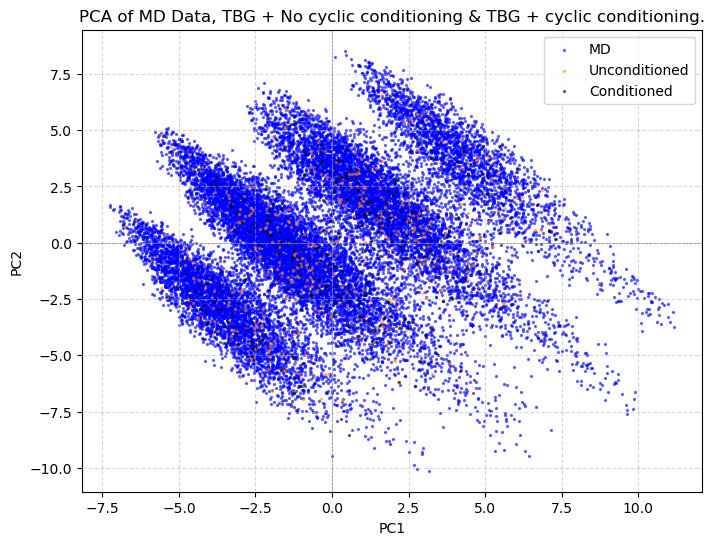

In [11]:
cond_cyc_unc_time_inference_vecs = data_to_dihedrals_vecs(pdb_path, cond_cyc_unc_time_inference_list)
#print(cond_cyc_unc_time_inference_vecs.shape)
cond_cyc_unc_time_inference_vecs = np_to_dihedrals_vecs(pdb_path, cond_cyc_samples_clean)
#print(cond_cyc_unc_time_inference_vecs.shape)

unc_cyc_unc_time_inference_vecs = data_to_dihedrals_vecs(pdb_path, unc_cyc_unc_time_inference_list)
#print(unc_cyc_unc_time_inference_vecs.shape)
unc_cyc_unc_time_inference_vecs = np_to_dihedrals_vecs(pdb_path, unc_cyc_samples_clean)
#print(unc_cyc_unc_time_inference_vecs.shape)


raw_val_vecs = data_to_dihedrals_vecs(pdb_path, raw_validation_data)

all_dihedral_vecs = np.concatenate([cond_cyc_unc_time_inference_vecs, unc_cyc_unc_time_inference_vecs, raw_val_vecs], axis=0)

#pcs=[pca_numpy(all_dihedral_vecs, 2)[0][:, i] for i in range(2)]
#pcs_arr = np.array(pcs) # (n_components, n_features)

pcs_arr = pcs_arr_init

all_mean = all_mean_init

# now, we project this data onto our pcs
proj_cond_cyc_unc_time = project_data(cond_cyc_unc_time_inference_vecs, pcs_arr, center = all_mean)
proj_unc_cyc_unc_time = project_data(unc_cyc_unc_time_inference_vecs, pcs_arr, center = all_mean)
proj_raw = project_data(raw_val_vecs, pcs_arr, center = all_mean)

plot_pca_scatter([proj_raw, proj_unc_cyc_unc_time, proj_cond_cyc_unc_time], colors = ['b', 'darkorange', 'black'], legend = ['MD', 'Unconditioned', 'Conditioned'], title= 'PCA of MD Data, TBG + No cyclic conditioning & TBG + cyclic conditioning.')

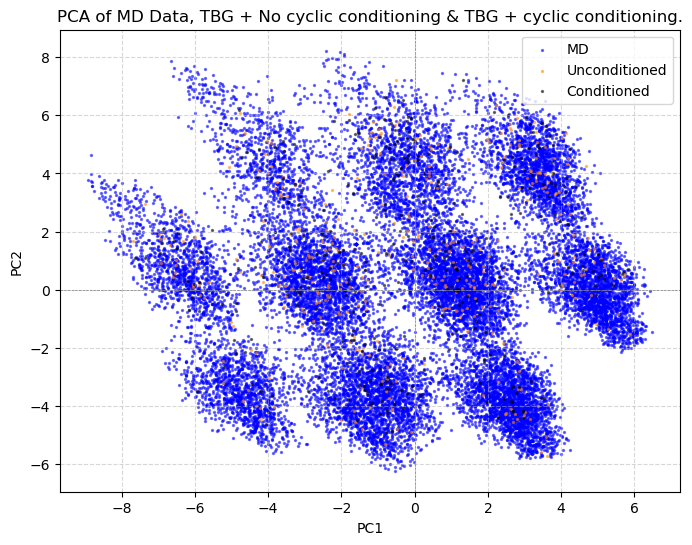

In [13]:
cond_cyc_unc_time_inference_vecs = data_to_dihedrals_vecs(pdb_path, cond_cyc_unc_time_inference_list)
#print(cond_cyc_unc_time_inference_vecs.shape)
cond_cyc_unc_time_inference_vecs = np_to_dihedrals_vecs(pdb_path, cond_cyc_samples_clean)
#print(cond_cyc_unc_time_inference_vecs.shape)

unc_cyc_unc_time_inference_vecs = data_to_dihedrals_vecs(pdb_path, unc_cyc_unc_time_inference_list)
#print(unc_cyc_unc_time_inference_vecs.shape)
unc_cyc_unc_time_inference_vecs = np_to_dihedrals_vecs(pdb_path, unc_cyc_samples_clean)
#print(unc_cyc_unc_time_inference_vecs.shape)
raw_val_vecs = data_to_dihedrals_vecs(pdb_path, raw_validation_data)

all_dihedral_vecs = np.concatenate([cond_cyc_unc_time_inference_vecs, unc_cyc_unc_time_inference_vecs, raw_val_vecs], axis=0)

pcs=[pca_numpy(all_dihedral_vecs, 2)[0][:, i] for i in range(2)]
pcs_arr = np.array(pcs) # (n_components, n_features)

all_mean = np.mean(all_dihedral_vecs, axis=0)

# now, we project this data onto our pcs
proj_cond_cyc_unc_time = project_data(cond_cyc_unc_time_inference_vecs, pcs_arr, center = all_mean)
proj_unc_cyc_unc_time = project_data(unc_cyc_unc_time_inference_vecs, pcs_arr, center = all_mean)
proj_raw = project_data(raw_val_vecs, pcs_arr, center = all_mean)

plot_pca_scatter([proj_raw, proj_unc_cyc_unc_time, proj_cond_cyc_unc_time], colors = ['b', 'darkorange', 'black'], legend = ['MD', 'Unconditioned', 'Conditioned'], title= 'PCA of MD Data, TBG + No cyclic conditioning & TBG + cyclic conditioning.')